In [57]:
from Bio import pairwise2
from itertools import product
import pandas as pd 
import numpy as np
import os 
from polyleven import levenshtein
from collections import Counter

In [166]:
#Levenshtein distance
def leven(Z):
    X,Y = iter(Z)
    scr = levenshtein(X, Y)
    distance = 1
    return 1 if scr <= distance else 0

### 1) Create a distance matrix (where 1, if levenshtein dictance <=1)

#### Top 1000 of clones

In [167]:
AB_clones = pd.read_csv("AB_FMBA_features/covid_status_top.txt", sep = '\t')
AB_clones_1000 = list(AB_clones.cdr3aa)[:1000]
len(AB_clones_1000)

1000

In [168]:
FMBA_clones = pd.read_csv("AB_FMBA_features/COVID_status_TRB_fmba_full_v2_pv.txt", sep = '\t')
FMBA_clones_1000 = list(FMBA_clones.cdr3aa)[:1000]
len(FMBA_clones_1000)

1000

In [169]:
comb = list(product(AB_clones_1000, FMBA_clones_1000))
print("lenght of array:", len(comb))
lev = list(map(leven, comb))
print('unique values:', set(lev))
mm = np.array(lev)
mm.shape = (1000, 1000)
AB_vs_FMBA_leven = pd.DataFrame(np.array(mm), index=AB_clones_1000, columns=FMBA_clones_1000)

AB_vs_FMBA_leven.to_csv("AB_vs_FMBA_leven_flat_dataframe_top1000.tsv", sep = '\t')

lenght of array: 1000000
unique values: {0, 1}


In [172]:
sum_occurrence_FMBA = np.apply_along_axis(sum, 0, mm)
edge_count_FMBA = [x for x in sum_occurrence_FMBA if x != 0]
print(len(edge_count_FMBA))
Counter(edge_count_FMBA)

29


Counter({1: 23, 8: 1, 2: 1, 7: 2, 4: 1, 9: 1})

In [174]:
sum_occurrence_AB = np.apply_along_axis(sum, 1, mm)
edge_count_AB = [x for x in sum_occurrence_AB if x != 0]
print(len(edge_count_AB))
Counter(edge_count_AB)

54


Counter({2: 4, 1: 49, 3: 1})

In [38]:
#not too many
print('total:', sum([54, 29]))

total: 83


#### Top 5000 of clones

In [53]:
#Let's take all of the COVID-associated clones with p-value < 0.05
print('lenght AB_clones:', len(AB_clones))
print('lenght FMBA_clones:', len(FMBA_clones))

AB_clones_5000 = list(AB_clones.cdr3aa)[:5000]
FMBA_clones_5000 = list(FMBA_clones.cdr3aa)[:5000]
len(AB_clones_5000)

lenght AB_clones: 20212
lenght FMBA_clones: 5190


5000

In [54]:
#Repeat step 1

comb = list(product(AB_clones_5000, FMBA_clones_5000))
print("lenght of array:", len(comb))
lev = list(map(leven, comb))
print('unique values:', set(lev))
mm = np.array(lev)
mm.shape = (5000, 5000)
AB_vs_FMBA_leven = pd.DataFrame(np.array(mm), index=AB_clones_5000, columns=FMBA_clones_5000)

AB_vs_FMBA_leven.to_csv("AB_vs_FMBA_leven_flat_dataframe_top5000.tsv", sep = '\t')

lenght of array: 25000000
unique values: {0, 1}


### 2) Find sequences that form clusters

#### Incidence of FMBA features

In [75]:
sum_occurrence_FMBA = np.apply_along_axis(sum, 0, mm)
edge_count_FMBA = [x for x in sum_occurrence_FMBA if x != 0]
len(edge_count_FMBA)

1101

In [78]:
Counter(edge_count_FMBA)

Counter({1: 697,
         2: 194,
         3: 68,
         5: 13,
         31: 1,
         6: 8,
         4: 30,
         16: 7,
         12: 6,
         23: 1,
         26: 2,
         8: 4,
         10: 7,
         19: 4,
         7: 6,
         25: 3,
         15: 8,
         18: 6,
         13: 7,
         21: 3,
         24: 3,
         9: 6,
         30: 1,
         17: 4,
         14: 5,
         27: 2,
         33: 2,
         11: 2,
         28: 1})

In [95]:
df_sum_occurrence_FMBA = pd.DataFrame.from_dict({'cdr3aa': FMBA_clones_5000, 'incidence': sum_occurrence_FMBA})
df_sum_occurrence_FMBA.shape

(5000, 2)

#### Incidence of Adaptive features

In [76]:
sum_occurrence_AB = np.apply_along_axis(sum, 1, mm)
edge_count_AB = [x for x in sum_occurrence_AB if x != 0]
len(edge_count_AB)

1703

In [77]:
Counter(edge_count_AB)

Counter({1: 993, 2: 426, 5: 22, 4: 72, 3: 153, 7: 14, 6: 18, 8: 4, 13: 1})

In [98]:
df_sum_occurrence_AB = pd.DataFrame.from_dict({'cdr3aa': AB_clones_5000, 'incidence': sum_occurrence_AB})
df_sum_occurrence_AB.shape

(5000, 2)

In [128]:
#concat two dataframes
incidence_of_features_AB_vs_FMBA = pd.concat([df_sum_occurrence_FMBA, df_sum_occurrence_AB])

In [129]:
incidence_of_features_AB_vs_FMBA = incidence_of_features_AB_vs_FMBA.set_index('cdr3aa')

In [130]:
#Drop common clones and clones with incidens < 2
common_clones = set(AB_clones_5000) & set(FMBA_clones_5000)
incidence_of_features_AB_vs_FMBA=incidence_of_features_AB_vs_FMBA.loc[set(incidence_of_features_AB_vs_FMBA.index.values) - common_clones,]
incidence_of_features_AB_vs_FMBA = incidence_of_features_AB_vs_FMBA.loc[incidence_of_features_AB_vs_FMBA['incidence']>=2]

In [161]:
incidence_of_features_AB_vs_FMBA_sorted = incidence_of_features_AB_vs_FMBA.sort_values('incidence', kind='mergesort',  ascending=False)
incidence_of_features_AB_vs_FMBA_sorted.to_csv("incidence_of_features_AB_vs_FMBA_sorted.tsv", sep = '\t')
incidence_of_features_AB_vs_FMBA_sorted.index.values


,incidence
cdr3aa,
CASSLTGNSPLHF,31
CASSRGNSPLHF,30
CASSLGRNSPLHF,28
CASSLAGNSPLHF,27
CASSPGNSPLHF,25
...,...
CASSLEVGGYTF,2
CASSGQYNSPLHF,2
CASSKGQYNSPLHF,2


### 3) Let's create a Graph

In [177]:
##Graph for top 5000 of clones
#Delete rows and columns that contained only zeros
AB_vs_FMBA_leven = pd.read_csv("AB_vs_FMBA_leven_flat_dataframe_top5000.tsv", sep = '\t', index_col=0)
AB_vs_FMBA_leven_without_zeros = AB_vs_FMBA_leven.loc[:, (AB_vs_FMBA_leven != 0).any(axis=0)]
AB_vs_FMBA_leven_without_zeros = AB_vs_FMBA_leven_without_zeros.loc[(AB_vs_FMBA_leven_without_zeros != 0).any(axis=1),:]
print(AB_vs_FMBA_leven_without_zeros.shape)
AB_vs_FMBA_leven_without_zeros = AB_vs_FMBA_leven_without_zeros.iloc[:1000,:1000]
AB_vs_FMBA_leven_without_zeros.shape


(1703, 1101)


(1000, 1000)

In [144]:
import networkx as nx
import matplotlib.pyplot as plt

#### Draw a Graph

In [142]:
G = nx.Graph(AB_vs_FMBA_leven_without_zeros.values)

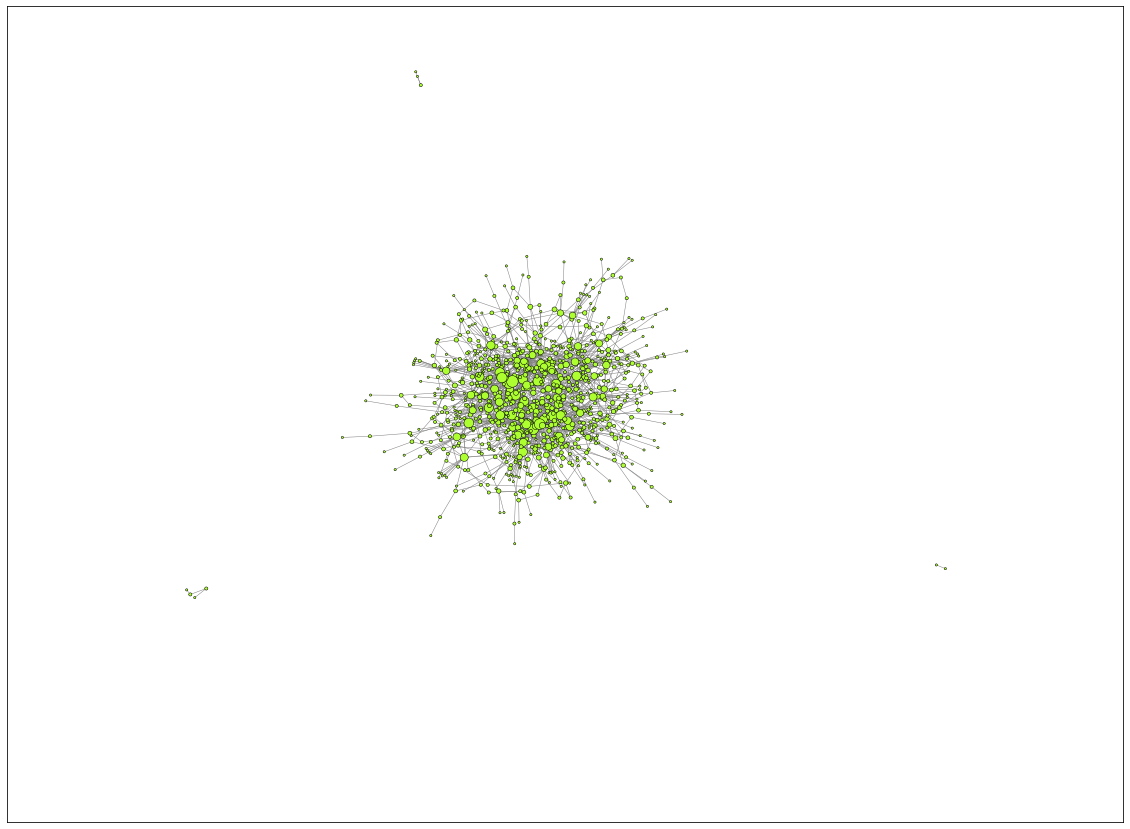

In [147]:
pos = nx.spring_layout(G)
#labels = {c: cln_lst1[c] for c in range(len(cln_lst1))}
plt.figure(10,figsize=(20,15)) 
d = dict(G.degree)
nx.draw_networkx_nodes(G,pos, node_color='greenyellow', node_size=[v * 5 for v in d.values()], linewidths=0.5, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray')
plt.show()

In [162]:
#Graph for top 1000 of clones
AB_vs_FMBA_leven = pd.read_csv("AB_vs_FMBA_leven_flat_dataframe_top1000.tsv", sep = '\t', index_col=0)

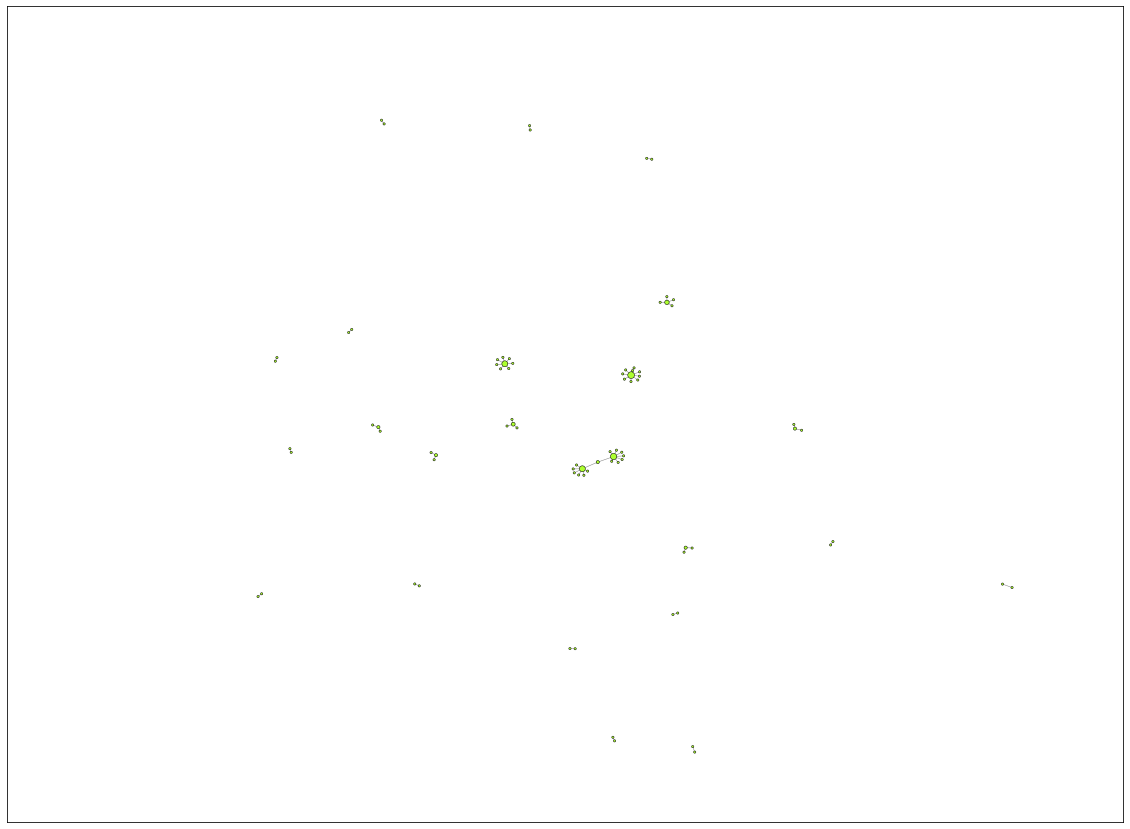

In [163]:
G = nx.Graph(AB_vs_FMBA_leven.values)
pos = nx.spring_layout(G)
#labels = {c: cln_lst1[c] for c in range(len(cln_lst1))}
plt.figure(10,figsize=(20,15)) 
d = dict(G.degree)
nx.draw_networkx_nodes(G,pos, node_color='greenyellow', node_size=[v * 5 for v in d.values()], linewidths=0.5, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray')
plt.show()